# Product Recognition on Store Shelves

In [1]:
print(":|")

:|


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [3]:
def print_image_path(image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

def print_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

## STEP A - Multiple Product Detection

Develop an object detection system to identify single instance of products given: one reference image for each item and a scene image. The system should be able to correctly identify all the product in the shelves image.

* The images with the products that must be detected are: *models/{0,1,11,19,24,25,26}.jpg*
* The test images are: *scenes/e{1,2,3,4,5}.png*

Let's detect keypoints in two images, a product and a scene, as an example.

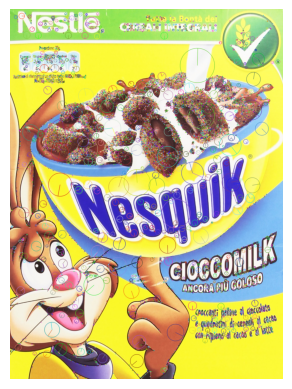

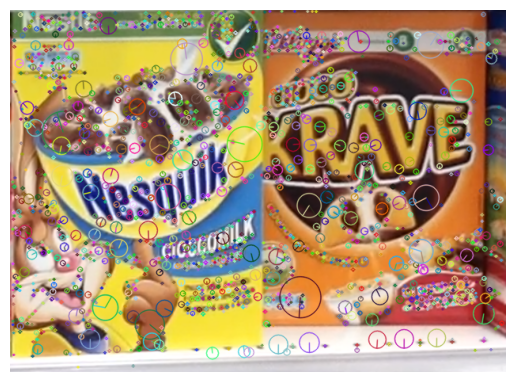

In [4]:
# Load the query and the train images
model_im = cv2.imread('models/0.jpg')
scene_im = cv2.imread('scenes/e1.png')

# Creating SIFT object
sift = cv2.SIFT_create()

# Detecting Keypoints in the
md_kp = sift.detect(model_im)
sc_kp = sift.detect(scene_im)

# Visualizing the found Keypoints
md_with_kp = cv2.drawKeypoints(model_im,md_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(md_with_kp)

sc_with_kp = cv2.drawKeypoints(scene_im,sc_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(sc_with_kp)

With the following code (we could erase this since it will be part of the system....) we find the product in the scene, calculate the homography, and print the bounding box of the product.

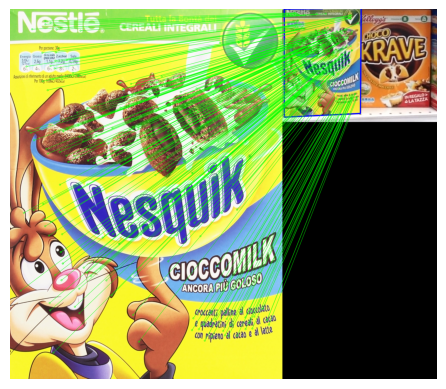

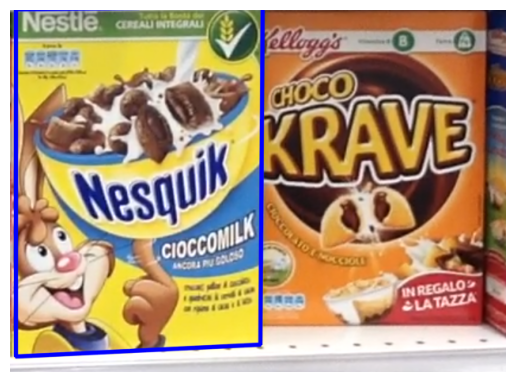

In [5]:
# Computing the descriptors for each keypoint
kp_model, des_model = sift.compute(model_im, md_kp)
kp_scene, des_scene = sift.compute(scene_im, sc_kp)

# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_model,des_scene,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)



# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = model_im.shape[0:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Drawing bounding box
    scene_im = cv2.polylines(scene_im,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(model_im,md_kp,scene_im,sc_kp,good,None,**draw_params)
print_image(img3)
print_image(scene_im)

### Step A - Some utility functions

In [6]:
# CONSTANTS used for images, keypoints, descriptors (returned by get_keypoints_and_descriptors())
ID = 0
KP = 1
DES = 2

# CONSTANTS used for width, heigth and centroid of objects found in the scene (returned by find_match())
CENTER = 0
WIDTH = 1
HEIGHT = 2


def extract_id_from_path(string):
    '''
    Given a full or local path of a file, it extracts the filename excluding the extension.

    Args:
        string: a path string such as "model/0.jpg" or "e1.jpg"

    Returns:
        string: the name of the file without the extension
    '''

    if "/" in string:
        string = string.split('/')[-1]
    if "." in string:
        string = string.split('.')[0]
    return string


def get_keypoints_and_descriptors(paths_im, mask=None):
    '''
    Given a list of image paths and a mask, the method detects the keypoints and compute
    their descriptors. It returns a specific tuple.

    Args:
        paths_im:   paths of the images
        mask:       mask that filters the space in which to search for keypoints

    Returns:
        prod_st:    list of tuples - (product_id, keypoint, description)
                        the product_id is extracted by the image filename.
        images:     list of the images read by disk
    '''

    # create the SIFT object and the Flann matcher
    sift = cv2.SIFT_create()

    prod_st = []        # empty list for the informations (id, keypoints, description)
    images = []         # empty list for the images
    for path in paths_im:
        im = cv2.imread(path)
        images.append(im)

        kp, des = sift.detectAndCompute(im, mask)
        product_id = extract_id_from_path(path)

        # append to the list a tuple that describes the product
        prod_st.append((product_id, kp, des))
    
    return prod_st, images

### Step A - The system

The class Simple_Finder will be used to perform a the detection of multiple products in a scene image.

In [7]:
class Simple_Finder:

    def __init__(self, paths_im):
        '''
        Saves the images and their descriptors (id, kp, des) in local structures, to improve the 
        reusability of the data during the detection process. It also initialize the Flann matcher.
        '''
        self.prods_st, self.images = get_keypoints_and_descriptors(paths_im, mask=None)
        self.flann = self.initialize_flann()


    def initialize_flann(self):
        '''Initializes the flann matcher with some default parameters'''
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        return cv2.FlannBasedMatcher(index_params, search_params)


    def find_match(self, product_st, scene_st, image):
        '''
        Given the KEYPOINTS, DESCRIPTIONS, IMAGE of model and train image (Product and Scene), 
        the function tries to find if the model is present in the train image

        Args:
            product_st:     the structure (id,kp,des) of the products
            scene:          the structure (id,kp,des) of the scene
            image:          product's image

        Returns:
            r_list:         list of found products, with the structure (center,width,height)
        '''

        r_list = []

        # Matching the descriptors
        matches = self.flann.knnMatch(product_st[DES],scene_st[DES],k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.3*n.distance:
                good.append(m)

        # If we have at least 10 matches we find the box of the object
        MIN_MATCH_COUNT = 10
        
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ product_st[KP][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ scene_st[KP][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            
            # Calculating homography based on correspondences
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
            # Apply homography to project corners of the query image into the image
            h,w = image.shape[0:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            # calculate central position of the object
            c_obj = tuple(np.int32(dst.mean(axis=0)).ravel())
            # width of the object (euclidean norm of the vector)
            w_obj = int(np.linalg.norm(dst[1].ravel() - dst[2].ravel()))
            # height of the object (euclidean norm of the vector)
            h_obj = int(np.linalg.norm(dst[0].ravel() - dst[1].ravel()))
                
            r_list.append((c_obj, w_obj, h_obj))

        return r_list


    def analyze_scene(self, path_scene):
        '''
        Given the path of a scene, the function searches for 
        the products in the scene by calling find_match().

        Args:
            path_scene: optional - paths of the scene image source

        Returns:
            description: a string description of which products were found in the scene
        '''

        if path_scene is None:
            print("ERROR: you must provide the path of a scene, to analyze it")
            return
        
        # get the keypoints and descriptors of the scene image
        scene_st, _ = get_keypoints_and_descriptors([path_scene], None)
        # the method provides a list, but we analyze one image -> get the first element.
        scene_st = scene_st[0]

        ## create a string for the final report
        str = ""
        
        for i in range(len(self.images)):
            
            # search for a single product in the scene
            found = self.find_match(self.prods_st[i], scene_st, self.images[i])
            
            # print informations about the object, if found
            if len(found) > 0:
                str += "Product {} - {} instance found:\n".format(self.prods_st[i][0],len(found))
                for i in range(len(found)):
                    str += "\tInstance {} {{position: {}, width: {}px, height: {}px}}\n".format(len(found), found[i][CENTER], found[i][WIDTH], found[i][HEIGHT])
                    
            i += 1

        return str


### Step A - execution
The following code performs the main execution of the Step A activity. A report containing a description of each product found in every scene will be printed and saved on disk.

In [8]:
## Main Code for the STEP A solution.
def step_A(p_images, p_scenes, report_path, verbose=False):
        '''
        Given the image paths of many products and scenes, the function tries to find if the products are present in the scene
        and saves the search results in the file specified by the report_path argument.

        Args:
            p_images:       list of products images paths
            p_scenes:       list of scenes images paths
            report_path:    path for the textual report file
            verbose:        if True, it also prints the report on terminal
        '''

        ## specify the file path where to print a full report of the analysis
        if report_path is None:
            print("Error: You must specify a report path")
            return

        # the system object used to perform the search during Step A.
        system = Simple_Finder(p_images)
        
        with open(report_path, 'w') as file:

            for path_scene in p_scenes:
            
                r_str = "Scene: {}:\n".format(path_scene) + system.analyze_scene(path_scene)
                file.write(r_str)
                file.write("\n\n")

                if verbose:
                    print(r_str)
                    print()

        return


paths_images = ['models/{}.jpg'.format(i) for i in {0,1,11,19,24,25,26}]
paths_scenes = ['scenes/e{}.png'.format(i) for i in {1,2,3,4,5}]

step_A(paths_images, paths_scenes, "report_step_A.txt", verbose=True)

Scene: scenes/e1.png:
Product 0 - 1 instance found:
	Instance 1 {position: (162, 214), width: 309px, height: 437px}
Product 1 - 1 instance found:
	Instance 1 {position: (445, 164), width: 296px, height: 387px}


Scene: scenes/e2.png:
Product 24 - 1 instance found:
	Instance 1 {position: (167, 219), width: 334px, height: 490px}
Product 25 - 1 instance found:
	Instance 1 {position: (877, 232), width: 314px, height: 447px}
Product 26 - 1 instance found:
	Instance 1 {position: (538, 217), width: 328px, height: 490px}


Scene: scenes/e3.png:
Product 0 - 1 instance found:
	Instance 1 {position: (171, 236), width: 324px, height: 442px}
Product 1 - 1 instance found:
	Instance 1 {position: (476, 185), width: 302px, height: 390px}


Scene: scenes/e4.png:
Product 0 - 1 instance found:
	Instance 1 {position: (158, 738), width: 321px, height: 445px}
Product 1 - 1 instance found:
	Instance 1 {position: (464, 686), width: 300px, height: 393px}
Product 25 - 1 instance found:
	Instance 1 {position: (55